## Albumentations

Albumentations is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

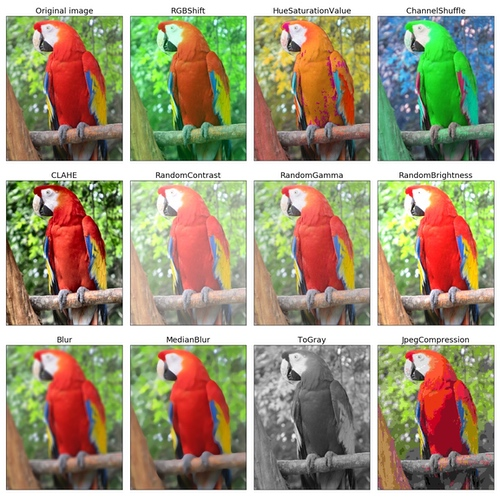

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

### Load Test Image

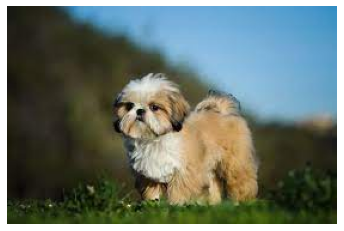

(182, 276, 3)


In [2]:
image = cv2.imread("../images/augmentation.jpg")

#Inver image channel BGR -> RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.axis('off')
plt.imshow(image)
plt.show()

print(image.shape)

### Set Augmentations with Albumentations

In [10]:
rotate = A.Rotate(limit=[-50, 50], p=1)

# Flip
flip = A.HorizontalFlip(p=1)

# Ruído Gaussiano
gaussian_noise = A.GaussNoise(var_limit=[90, 150], p=1)

# Crop
crop = A.RandomCrop(height=int(image.shape[0]*0.6),
                    width=int(image.shape[1]*0.6), p=1)

# Sharpen
sharpen = A.IAASharpen(alpha=(0, 1.0), lightness=(0.75, 3), p=1)

# Translação, Scale, Rotação
heavy_affine = A.ShiftScaleRotate(shift_limit=0.0625,
                                  scale_limit=0.2,
                                  rotate_limit=45,
                                  p=1)



### Perform Augmentations

In [11]:
image_rotate = rotate(image=image)
image_flip = flip(image=image)
image_gaussian_noise = gaussian_noise(image=image)
image_crop = crop(image=image)
image_sharpen = sharpen(image=image)
image_heavy_affine = heavy_affine(image=image)

### Show Augmentations

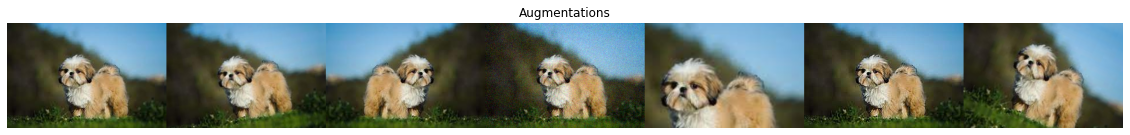

In [12]:
images_aug = [image,
              image_rotate['image'],
              image_flip['image'],
              image_gaussian_noise['image'],
              cv2.resize(image_crop['image'], (image.shape[1], image.shape[0])),
              image_sharpen['image'],
              image_heavy_affine['image']
              ]

# plot augmentation examples
plt.figure(figsize=(20, 10))
plt.title('Augmentations')
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.show()

### Set Augmentation Pipeline

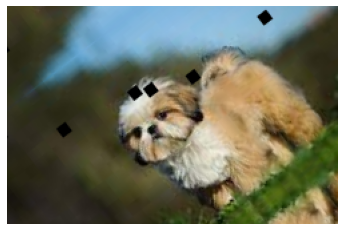

In [18]:
# compose augmentation pipeline
aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(height=int(image.shape[0] * 0.9), width=int(image.shape[1] * 0.9)),
    A.GaussNoise(var_limit=[10, 60], p=0.5),
    A.RandomContrast(limit=1.5, p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(1, 3)),
        A.Blur(blur_limit=(2, 7)),
        A.MedianBlur(blur_limit=(3, 11))
    ]),
    A.IAASharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    A.IAAAdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    A.OneOf([
        A.ChannelDropout(channel_drop_range=(1, 3)),
        A.CoarseDropout(max_holes=8),
    ]),
    A.ShiftScaleRotate(shift_limit=0.0625,
                                      scale_limit=0.2,
                                      rotate_limit=45,
                                      p=1),
], p=1)


aug_image = aug_pipeline(image=image)


plt.axis('off')
plt.imshow(aug_image['image'])
plt.show()

### Work with Bounding Box + Visualization Tool

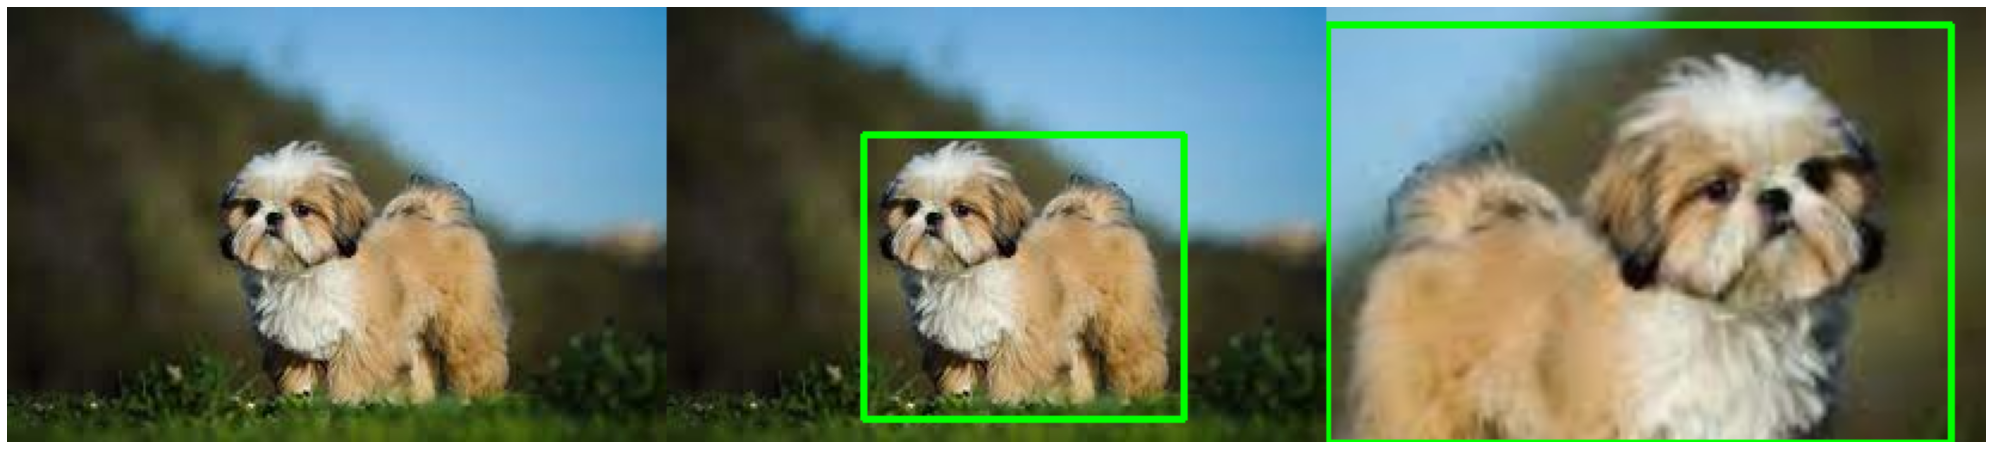

In [19]:
x1, y1, x2, y2 = (82, 53, 216, 172)

image_bb = image.copy()
image_bb = cv2.rectangle(image_bb, (x1, y1), (x2, y2), (0, 255, 0), 2)


# Set Light Augmentation
transform = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.ShiftScaleRotate(shift_limit=0.002,
                           scale_limit=(0.2, 1.0),
                           rotate_limit=(-20, 20),
                           p=1),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


# Augment BBs and images.
transformed = transform(image=image, bboxes=[[x1, y1, x2, y2]], category_ids=["dog"])
image_aug, bbs_aug = (transformed['image'], transformed['bboxes'])


x1, y1, x2, y2 = bbs_aug[0]
image_aug = cv2.rectangle(image_aug, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

plt.figure(figsize=(50, 8))
plt.axis('off')
plt.imshow(np.hstack([image, image_bb, image_aug]))
plt.show()

### Work with Segmentation Mask + Visualization Tool

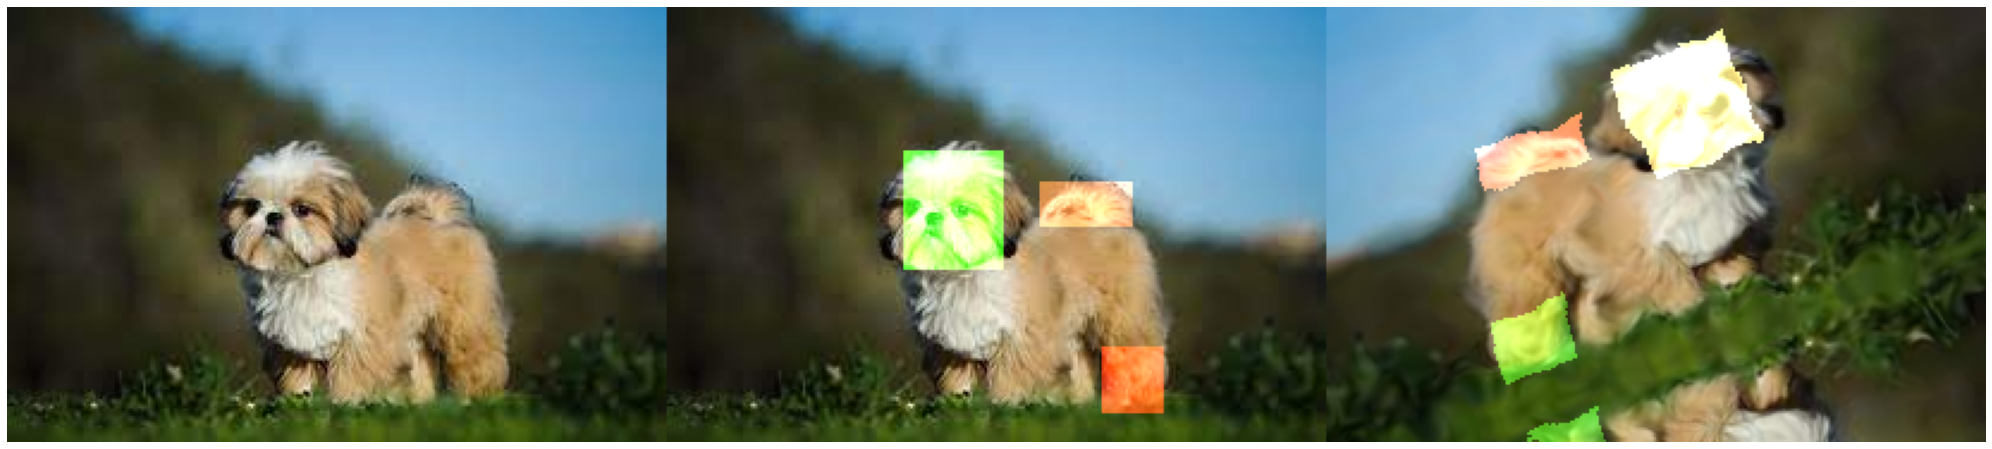

In [20]:
def draw_mask(img, mask):
 
    for seg_map in np.unique(mask):
        if seg_map == 0:
            continue
        i_mask = np.zeros_like(mask, dtype="uint8")
        bg = np.zeros_like(img, dtype="uint8")
        bg[:] = tuple(np.random.randint(255, size=(3, )))
        i_mask[mask==seg_map] = 255
        _, i_mask = cv2.threshold(i_mask, 250, 255, cv2.THRESH_BINARY)
        masked_img = cv2.bitwise_and(bg, bg, mask=i_mask)
        img = cv2.add(img, masked_img)
    return img
    

segmap = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.int32)
segmap[60:110, 99:141, 0] = 1
segmap[142:170, 182:208, 0] = 2
segmap[73:92, 156:195, 0] = 3

# Set Light Augmentation
transform = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.ElasticTransform(alpha=50, sigma=5, p=1)
    ],
)

augmented = transform(image=image, mask=segmap)   
image_aug, segmap_aug = (augmented['image'], augmented['mask'])

original_masked = draw_mask(image, segmap)
aug_masked = draw_mask(image_aug, segmap_aug)

plt.figure(figsize=(50, 8))
plt.axis('off')
plt.imshow(np.hstack([image, original_masked, aug_masked]))
plt.show()